In [1]:
# 1. Thêm các thư viện cần thiết
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.utils import np_utils
from keras.datasets import mnist

Load dữ liệu từ MNIST dataset, bao gồm 60.000 training set và 10.000 test set. Sau đó chia bộ traning set thành 2: 50.000 cho training set và 10.000 dữ liệu cho validation set.

In [2]:
# 2. Load dữ liệu MNIST
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_val, y_val = X_train[50000:60000,:], y_train[50000:60000]
X_train, y_train = X_train[:50000,:], y_train[:50000]
print(X_train.shape)
print(X_val.shape)

11493376/11490434 [==============================] - 0s 0us/step
(50000, 28, 28)
(10000, 28, 28)


Dữ liệu input cho mô hình convolutional neural network là 1 tensor 4 chiều (N, W, H, D), trong bài này là ảnh xám nên W = H = 28, D = 1, N là số lượng ảnh cho mỗi lần training. Do dữ liệu ảnh ở trên có kích thước là (N, 28, 28) tức là (N, W, H) nên rần reshape lại thành kích thước N * 28 * 28 * 1 để giống kích thước mà keras yêu cầu.

In [3]:
# 3. Reshape lại dữ liệu cho đúng kích thước mà keras yêu cầu
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_val = X_val.reshape(X_val.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)

X_train = X_train/255.
X_test = X_test/255.
X_val = X_val/255.
print(X_train.shape)

(50000, 28, 28, 1)


Bước này chuyển đổi one-hot encoding label Y của ảnh ví dụ số 5 thành vector [0, 0, 0, 0, 0, 1, 0, 0, 0, 0]

In [4]:
# 4. One hot encoding label (Y)
Y_train = np_utils.to_categorical(y_train, 10)
Y_val = np_utils.to_categorical(y_val, 10)
Y_test = np_utils.to_categorical(y_test, 10)
print('Dữ liệu y ban đầu ', y_train[0])
print('Dữ liệu y sau one-hot encoding ',Y_train[0])

Dữ liệu y ban đầu  5
Dữ liệu y sau one-hot encoding  [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]


Bước này định nghĩa model:
1. Model = Sequential() để nói cho keras là ta sẽ xếp các layer lên nhau để tạo model. Ví dụ input -> CONV -> POOL -> CONV -> POOL -> FLATTEN -> FC -> OUTPUT
2.  Ở layer đầu tiên cần chỉ rõ input_shape của ảnh, input_shape = (W, H, D), ta dùng ảnh xám kích thước (28,28) nên input_shape = (28, 28, 1)
3. Khi thêm Convolutional Layer ta cần chỉ rõ các tham số: K (số lượng layer), kernel size (W, H), hàm activation sử dụng. cấu trúc: model.add(Conv2D(K, (W, H), activation='tên_hàm_activation'))
4. Khi thêm Maxpooling Layer cần chỉ rõ size của kernel, model.add(MaxPooling2D(pool_size=(W, H)))
5. Bước Flatten chuyển từ tensor sang vector chỉ cần thêm flatten layer.
6. Để thêm Fully Connected Layer (FC) cần chỉ rõ số lượng node trong layer và hàm activation sử dụng trong layer, cấu trúc: model.add(Dense(số_lượng_node activation='tên_hàm activation'))


In [5]:
# BatchNormalization()
# Init Weight ()

# 5. Định nghĩa model
model = Sequential()
 
# Thêm Convolutional layer với 32 kernel, kích thước kernel 3*3
# dùng hàm sigmoid làm activation và chỉ rõ input_shape cho layer đầu tiên
model.add(Conv2D(32, (3, 3), padding='same', activation='relu', input_shape=(28,28,1)))

# Thêm Convolutional layer
model.add(Conv2D(32, (3, 3), activation='relu'))

# Thêm Max pooling layer
model.add(MaxPooling2D())

# Flatten layer chuyển từ tensor sang vector
model.add(Flatten())

# Thêm Fully Connected layer với 128 nodes và dùng hàm sigmoid
model.add(Dense(128, activation='relu'))

# Output layer với 10 node và dùng softmax function để chuyển sang xác xuất.
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        9248      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               692352    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 703,210
Trainable params: 703,210
Non-trainable params: 0
__________________________________________________

In [ ]:
# 6. Compile model, chỉ rõ hàm loss_function nào được sử dụng, phương thức 
# đùng để tối ưu hàm loss function.
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
# 7. Thực hiện train model với data
H = model.fit(X_train, Y_train, validation_data=(X_val, Y_val),
          batch_size=32, epochs=10, verbose=1)

Train on 50000 samples, validate on 10000 samples
Epoch 1/10
50000/50000 [==============================] - 8s 160us/step - loss: 0.1316 - acc: 0.9594 - val_loss: 0.0556 - val_acc: 0.9847
Epoch 2/10
50000/50000 [==============================] - 7s 145us/step - loss: 0.0412 - acc: 0.9875 - val_loss: 0.0532 - val_acc: 0.9845
Epoch 3/10
50000/50000 [==============================] - 7s 145us/step - loss: 0.0261 - acc: 0.9917 - val_loss: 0.0509 - val_acc: 0.9853
Epoch 4/10
50000/50000 [==============================] - 7s 144us/step - loss: 0.0170 - acc: 0.9944 - val_loss: 0.0545 - val_acc: 0.9843
Epoch 5/10
50000/50000 [==============================] - 7s 145us/step - loss: 0.0125 - acc: 0.9956 - val_loss: 0.0537 - val_acc: 0.9882
Epoch 6/10
50000/50000 [==============================] - 7s 144us/step - loss: 0.0114 - acc: 0.9961 - val_loss: 0.0497 - val_acc: 0.9871
Epoch 7/10
50000/50000 [==============================] - 7s 145us/step - loss: 0.0088 - acc: 0.9968 - val_loss: 0.0573 - 

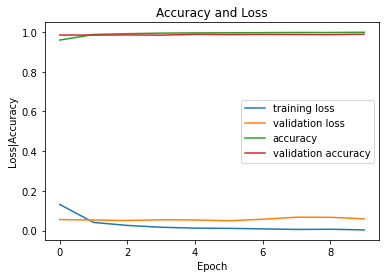

In [ ]:
# 8. Vẽ đồ thị loss, accuracy của traning set và validation set
fig = plt.figure()
numOfEpoch = 10
plt.plot(np.arange(0, numOfEpoch), H.history['loss'], label='training loss')
plt.plot(np.arange(0, numOfEpoch), H.history['val_loss'], label='validation loss')
plt.plot(np.arange(0, numOfEpoch), H.history['acc'], label='accuracy')
plt.plot(np.arange(0, numOfEpoch), H.history['val_acc'], label='validation accuracy')
plt.title('Accuracy and Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss|Accuracy')
plt.legend()

In [ ]:
# 9. Đánh giá model với dữ liệu test set
score = model.evaluate(X_test, Y_test, verbose=0)
print(score)

[0.055916523127659455, 0.9894]


Ta sẽ dùng kết quả đánh giá của mode với test set để làm kết quả cuối cùng của model. Tức model của chúng ta dữ đoán chữ số có độ chính xác 98.92% với MNIST dataset. Nghĩa là dự đoán khoảng 100 ảnh thì sai 1 ảnh.

Giá trị dự đoán:  7


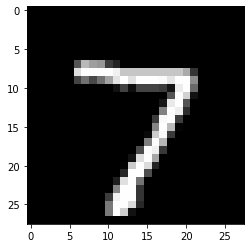

In [ ]:
# 10. Dự đoán ảnh
plt.imshow(X_test[0].reshape(28,28), cmap='gray')

y_predict = model.predict(X_test[0].reshape(1,28,28,1))
print('Giá trị dự đoán: ', np.argmax(y_predict))